# Taxon definition and lineage

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import toytree
import toyplot
import scipy.stats as sc

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from adascape.base import IR12SpeciationModel, DD03SpeciationModel
from adascape.fastscape_ext import FastscapeElevationTrait

## Functions to compute and visualize speciation model

In [2]:
def run_model(trait_comp=False, num_gen=100, pop_size = 10, dt=1,
             sigma_env_trait=0.3, mut_prob=1.0, sigma_mut=0.05, sigma_mov=5,
             random_seed=1234, distance_value=0.1, distance_metric='centroid',
              taxon_def='spec_clus',always_direct_parent=True):
    length = (250, 250)
    spacing = (1, 1)
    X, Y = np.meshgrid(*[np.arange(0, l + s, s) for l, s in zip(length, spacing)])
    r = np.random.RandomState(0)
    environment = X + r.rand(*Y.shape)
    trait_01_elev = FastscapeElevationTrait(topo_elevation=environment,
                                        init_trait_min=0.5,
                                        init_trait_max=0.5,
                                        lin_slope=0.95, 
                                        norm_min=environment.min(), 
                                        norm_max=environment.max(), 
                                        random_seed=1234)
    trait_01_elev.initialize()
    init_trait_funcs =  {
    'trait_1': trait_01_elev.init_trait_func,
    }
    opt_trait_funcs = {
    'trait_1': trait_01_elev.opt_trait_func
    }
    
    if trait_comp:
        model = DD03SpeciationModel(X, Y, init_trait_funcs, opt_trait_funcs, pop_size,
                                    car_cap_max=250, sigma_env_trait=sigma_env_trait, mut_prob=mut_prob, 
                                    sigma_mut=sigma_mut, sigma_mov=sigma_mov, sigma_comp_trait=sigma_env_trait, 
                                    sigma_comp_dist=sigma_env_trait, random_seed=random_seed, 
                                    distance_metric=distance_metric, distance_value=distance_value, 
                                    taxon_def=taxon_def, always_direct_parent=always_direct_parent)
    else:
        model = IR12SpeciationModel(X, Y, init_trait_funcs, opt_trait_funcs, pop_size, 
                                    nb_radius=50, car_cap=25, sigma_env_trait=sigma_env_trait, mut_prob=mut_prob, 
                                    sigma_mut=sigma_mut, sigma_mov=sigma_mov, random_seed=random_seed, 
                                    distance_value=distance_value, distance_metric=distance_metric, 
                                    taxon_def=taxon_def, always_direct_parent=always_direct_parent)

    model.initialize()
    dfs = []
    for step in range(num_gen):
        model.evaluate_fitness(dt)
        dfs.append(model.to_dataframe())
        model.update_individuals(dt)
    return pd.concat(dfs).reset_index(drop=True), environment, X

In [3]:
def plot_sol(dtf, elevation, X):
    num_gen = dtf.step.unique().size
    fig1, axs1 = plt.subplots(2, 2, sharex="col", figsize=(12, 6))
    axs1[0,0].plot(dtf.groupby('step').size())
    h,xedge,yedge,_=axs1[1,0].hist2d(x=dtf['step'], y=dtf['trait_0'],
                                     range=((0, num_gen), (0, 1)),
                                     bins=(num_gen, 100), cmap='bone_r')
    axs1[0, 1].pcolormesh(elevation)
    axs1[0, 1].scatter(dtf['x'].loc[dtf['step']==max(dtf['step'])],
                       dtf['y'].loc[dtf['step']==max(dtf['step'])],
                       c=dtf['trait_0'].loc[dtf['step']==max(dtf['step'])],
                       edgecolor='w',vmin=0, vmax=1)
    h,xedge,yedge,_=axs1[1,1].hist2d(x=dtf['x'].loc[dtf['step']==max(dtf['step'])],
                                     y=dtf['trait_0'].loc[dtf['step']==max(dtf['step'])],
                                     range=((0, X.max()), (0, 1)),
                                     bins=(25, 250), cmap='bone_r')
    axs1[0, 1].yaxis.set_label_position("right")
    axs1[0, 1].yaxis.tick_right()
    axs1[1, 1].yaxis.set_label_position("right")
    axs1[1, 1].yaxis.tick_right()
    axs1[0, 1].set_ylabel('Y', weight='bold')
    axs1[0, 0].set_ylabel('Abundance (No. ind)', weight='bold')
    axs1[1, 1].set_ylabel('Trait', weight='bold')
    axs1[1, 0].set_ylabel('Trait', weight='bold')
    axs1[1, 1].set_xlabel('X', weight='bold')
    axs1[1, 0].set_xlabel('Time (generations)', weight='bold')

In [4]:
def toytree_plot(tree, ind_dtf):
    """
    Plot of phylogenetic tree using library toytree and following the cookbook example 
    https://toytree.readthedocs.io/en/latest/
    
    Parameters
    ----------
    tree : class 'dendropy.tree'
        Phylogenetic tree as class dendropy.tree
    ind_dtf : class 'pandas.DataFrame'
        Speciation model output with data for all individuals
        
    """
    ttree = toytree.tree(tree.as_string(schema='newick'))
    # generate a distribution between 0 and 1 for each tip in the tree
    points = np.linspace(0, 1, 50)
    dists = {}
    for tip in ttree.get_tip_labels():
        trait_values = ind_dtf[ind_dtf.taxon_id==int(tip)].trait_0.values
        if trait_values.size > 1:
            kernel = sc.gaussian_kde(trait_values)                                 
            dists[tip] = kernel(points)
        else:
            dists[tip] = None
    # set up canvas for two panel plot
    canvas = toyplot.Canvas(width=300, height=400)

    # add tree to canvas
    ax0 = canvas.cartesian(bounds=(50, 180, 50, 350), ymin=0, ymax=ttree.ntips, padding=15)
    ttree.draw(axes=ax0, tip_labels=False)
    ax0.show = False

    # add histograms to canvas
    ax1 = canvas.cartesian(bounds=(200, 275, 50, 350), ymin=0, ymax=ttree.ntips, padding=15)

    # iterate from top to bottom (ntips to 0)
    for tip in range(ttree.ntips)[::-1]:

        # select a color for hist
        color = toytree.colors[int((tip) / 100)]

        # get tip name and get hist from dict
        tipname = ttree.get_tip_labels()[tip]
        probs = dists[tipname]
        
        if probs is not None:
            
            # fill histogram with slightly overlapping histograms
            ax1.fill(
                points, probs / probs.max() * 1.25,
                baseline=[tip] * len(points),
                style={"fill": color, "stroke": "white", "stroke-width": 0.5},
                title=tipname,
            )
            # add horizontal line at base
            ax1.hlines(tip, opacity=0.5, color="grey", style={"stroke-width": 0.5})

    # hide y axis, show x
    ax1.y.show = False
    ax1.x.label.text = "Trait value"
    ax1.x.ticks.show = True

## Phylogeny for the speciation model without trait-mediated competition

In [5]:
ind_dtf1, elevation1, X1 = run_model(trait_comp=False)

/Users/acevedo/opt/anaconda3/envs/adascape-dev/lib/python3.10/site-packages/scipy/cluster/vq.py:603: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


In [6]:
ind_dtf1

,step,time,dt,x,y,taxon_id,ancestor_id,n_offspring,fitness,trait_0
0,0,0.0,0.0,244.174942,110.251531,1,0,8,0.321987,0.500000
1,0,0.0,0.0,95.048934,152.467702,1,0,8,0.932487,0.500000
2,0,0.0,0.0,230.811558,215.905324,1,0,10,0.405734,0.500000
3,0,0.0,0.0,65.423106,215.939418,1,0,5,0.751070,0.500000
4,0,0.0,0.0,79.774265,168.720328,1,0,5,0.853670,0.500000
...,...,...,...,...,...,...,...,...,...,...
22265,99,99.0,0.0,157.545379,47.339532,2497,2447,1,0.992118,0.662593
22266,99,99.0,0.0,179.181266,27.824310,2500,2450,1,0.962680,0.621488
22267,99,99.0,0.0,178.984264,116.579489,2486,2436,1,0.716535,0.949514
22268,99,99.0,0.0,243.683493,42.582969,2502,2452,1,0.918769,0.828686


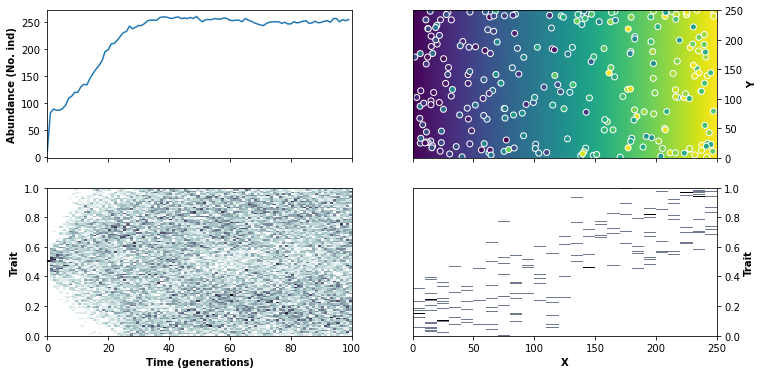

In [7]:
plot_sol(ind_dtf1, elevation1, X1)

In [8]:
taxon_lineage1 = ind_dtf1.ptree.extract_taxon_summary()
taxon_lineage1

,time,taxon_id,ancestor_id,trait_0,abundance,node_type
0,0.0,1,0,0.500000,10,root
1,1.0,2,1,0.497056,81,node
2,2.0,3,2,0.497222,88,node
3,3.0,4,3,0.494617,86,node
4,4.0,5,4,0.509961,86,node
...,...,...,...,...,...,...
2497,99.0,2498,2448,0.723075,4,leaf
2498,99.0,2499,2449,0.699582,4,leaf
2499,99.0,2500,2450,0.751013,4,leaf
2500,99.0,2501,2451,0.778593,9,leaf


In [9]:
tree1 = ind_dtf1.ptree.to_dendropy_tree()

In [10]:
tree1.print_plot()

                          ++++++++++++++++++++++++++++++++++++++++++++++++ 2453
                          |                                                    
                          |                  /++++++++++++++++++++++++++++ 2454
                          |  /++++++++++++++++                                 
                          |  |               \++++++++++++++++++++++++++++ 2455
                       ++++  |                                                 
                       |  |  |              /+++++++++++++++++++++++++++++ 2456
                       |  |  |              |                                  
                       |  |  |              |                          /++ 2457
                       |  |  |             /+           ++++++++++++++++       
                       |  ++++             ||           |              |/+ 2458
                       |     |             ||          /+              \+      
                       |     |          

In [11]:
toytree_plot(tree1, ind_dtf1)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="300.0px" height="400.0px" viewBox="0 0 300.0 400.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tc0ea05f461824164bbf38223a73218f3"> <polygon points="200.0,55.88235294117648 201.53061224489795,55.88235294117648 203.0612244897959,55.88235294117648 204.59183673469389,55.88235294117648 206.12244897959187,55.88235294117648 207.6530612244898,55.88235294117648 209.18367346938774,55.88235294117648 210.71428571428572,55.88235294117648 212.24489795918367,55.88235294117648 213.77551020408163,55.88235294117648 215.30612244897958,55.88235294117648 216.83673469387753,55.88235294117648 218.36734693877548,55.88235294117648 219.8979591836735,55.88235294117648 221.42857142857144,55.88235294117648 222.9591836734694,55.88235294117648 224.48979591836735,55.88235294117648 226.0204081632653,55.88235294117648 227.55102040816325,55.88235294117648 229.0816326530612,55.88235294117648 230.61224489795916,55.88235294117648 232.1428571428571,55.88235294117648 233.6734693877551,55.88235294117648 235.20408163265304,55.88235294117648 236.73469387755102,55.88235294117648 238.26530612244898,55.88235294117648 239.79591836734693,55.88235294117648 241.3265306122449,55.88235294117648 242.85714285714286,55.88235294117648 244.3877551020408,55.88235294117648 245.91836734693877,55.88235294117648 247.44897959183675,55.88235294117648 248.9795918367347,55.88235294117648 250.51020408163265,55.88235294117648 252.0408163265306,55.88235294117648 253.57142857142858,55.88235294117648 255.10204081632654,55.88235294117648 256.6326530612245,55.88235294117648 258.16326530612247,55.88235294117648 259.6938775510204,55.88235294117648 261.2244897959184,55.88235294117648 262.7551020408163,55.88235294117648 264.2857142857143,55.88235294117648 265.81632653061223,55.88235294117648 267.3469387755102,55.88235294117648 268.8775510204082,55.88235294117648 270.4081632653061,55.88235294117648 271.9387755102041,55.88235294117648 273.469387755102,55.88235294117648 275.0,55.88235294117648 275.0,51.645752990969 273.469387755102,51.08596796887713 271.9387755102041,50.55266538411849 270.4081632653061,50.06395032126583 268.8775510204082,49.63477206201479 267.3469387755102,49.27553571885752 265.81632653061223,48.99127788467906 264.2857142857143,48.781542954547 262.7551020408163,48.640985324147884 261.2244897959184,48.56060386235222 259.6938775510204,48.529411764705884 258.16326530612247,48.536276831044425 256.6326530612245,48.57164651626309 255.10204081632654,48.62890084353631 253.57142857142858,48.70514647976669 252.0408163265306,48.80136148121037 250.51020408163265,48.92190359935926 248.9795918367347,49.07348788963248 247.44897959183675,49.26380855426964 245.91836734693877,49.50001848971461 244.3877551020408,49.787286704225565 242.85714285714286,50.12763161503774 241.3265306122449,50.51918257769253 239.79591836734693,50.955959366617975 238.26530612244898,51.42818712355358 236.73469387755102,51.92309102525248 235.20408163265304,52.42605015407717 233.6734693877551,52.92194347095378 232.1428571428571,53.39650031999154 230.61224489795916,53.837477455685374 229.0816326530612,54.23552241755055 227.55102040816325,54.58464153935593 226.0204081632653,54.88225801076919 224.48979591836735,55.128907870178956 222.9591836734694,55.32766822843375 221.42857142857144,55.48343565091383 219.8979591836735,55.6021724785154 218.36734693877548,55.69021918829432 216.83673469387753,55.7537392787536 215.30612244897958,55.7983281401449 213.77551020408163,55.82878621300874 212.24489795918367,55.84903410257931 210.71428571428572,55.86213486192622 209.18367346938774,55.870385517151185 207.6530612244898,55.87544364322794 206.

## Tree summary statistics 

Phylogenetic diversity (PD)

In [12]:
sum(tree1.calc_node_root_distances())

5026.0

In [13]:
pdm1=tree1.phylogenetic_distance_matrix()

Mean pairwise distance (MPD)

In [14]:
pdm1.mean_pairwise_distance()

153.97803921568627

Mean neighbor taxon distance (MNTD)

In [15]:
pdm1.mean_nearest_taxon_distance()

75.76470588235294

Lineages through time (LTT)

Text(0, 0.5, 'Number of Lineages')

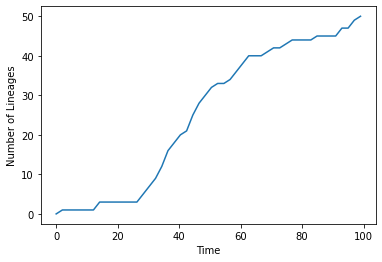

In [16]:
time_steps1 = np.linspace(0, tree1.max_distance_from_root(), 50)
ltt1=[tree1.num_lineages_at(t) for t in time_steps1]
plt.plot(time_steps1, ltt1)
plt.xlabel('Time')
plt.ylabel('Number of Lineages')

## Phylogeny for the speciation model with trait-mediated competition

In [17]:
ind_dtf2, elevation2, X2 = run_model(trait_comp=True)

/Users/acevedo/opt/anaconda3/envs/adascape-dev/lib/python3.10/site-packages/scipy/cluster/vq.py:603: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


In [18]:
ind_dtf2

,step,time,dt,x,y,taxon_id,ancestor_id,n_offspring,events_i,death_i,trait_0
0,0,0.0,0.0,244.174942,110.251531,1,0,2,B,0.069492,0.500000
1,0,0.0,0.0,95.048934,152.467702,1,0,1,M,0.063454,0.500000
2,0,0.0,0.0,230.811558,215.905324,1,0,1,M,0.059319,0.500000
3,0,0.0,0.0,65.423106,215.939418,1,0,1,M,0.068145,0.500000
4,0,0.0,0.0,79.774265,168.720328,1,0,2,B,0.067284,0.500000
...,...,...,...,...,...,...,...,...,...,...,...
16355,99,99.0,1.0,134.775231,69.719191,1196,1153,1,M,1.333339,0.842608
16356,99,99.0,1.0,242.417454,88.456198,1196,1153,1,M,1.466753,0.648077
16357,99,99.0,1.0,248.073473,125.680767,1196,1153,1,M,1.439968,0.655372
16358,99,99.0,1.0,216.241197,85.128369,1194,1151,2,B,1.347769,0.702076


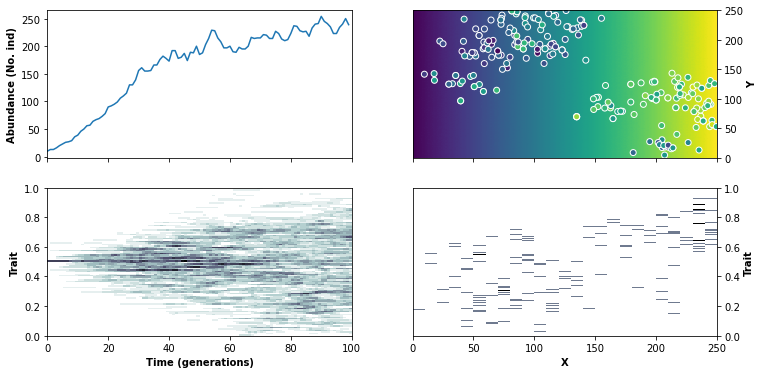

In [19]:
plot_sol(ind_dtf2, elevation2, X2)

In [20]:
taxon_lineage2 = ind_dtf2.ptree.extract_taxon_summary()
taxon_lineage2

,time,taxon_id,ancestor_id,trait_0,abundance,node_type
0,0.0,1,0,0.500000,10,root
1,1.0,2,1,0.510839,13,node
2,2.0,3,2,0.510839,13,node
3,3.0,4,3,0.514853,16,node
4,4.0,5,4,0.510981,20,node
...,...,...,...,...,...,...
1200,99.0,1201,1158,0.473798,7,leaf
1201,99.0,1202,1159,0.376896,5,leaf
1202,99.0,1203,1160,0.460305,3,leaf
1203,99.0,1204,1161,0.533588,10,leaf


In [21]:
tree2 = ind_dtf2.ptree.to_dendropy_tree()

In [22]:
tree2.print_plot()

                                               /----------------++++++++++ 387 
                                            ++++                               
                                            |  | /++++++++++++++++++++++++ 1163
                                            |  +++                             
                                            |    | /++++++++++++++++++++++ 1164
                                            |    \++                           
                                            |      |                ++++++ 1165
                                            |      \+++++++++++++++++          
                                            |                       ++++++ 1166
                                            |                                  
                                            |                 /+++++++++++ 1167
                                            |  ++++++++++++++++                
                                        

In [23]:
toytree_plot(tree2, ind_dtf2)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="300.0px" height="400.0px" viewBox="0 0 300.0 400.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t32d96f6ccfde46a4bac242686d9ae3d3"> <polygon points="200.0,55.76923076923078 201.53061224489795,55.76923076923078 203.0612244897959,55.76923076923078 204.59183673469389,55.76923076923078 206.12244897959187,55.76923076923078 207.6530612244898,55.76923076923078 209.18367346938774,55.76923076923078 210.71428571428572,55.76923076923078 212.24489795918367,55.76923076923078 213.77551020408163,55.76923076923078 215.30612244897958,55.76923076923078 216.83673469387753,55.76923076923078 218.36734693877548,55.76923076923078 219.8979591836735,55.76923076923078 221.42857142857144,55.76923076923078 222.9591836734694,55.76923076923078 224.48979591836735,55.76923076923078 226.0204081632653,55.76923076923078 227.55102040816325,55.76923076923078 229.0816326530612,55.76923076923078 230.61224489795916,55.76923076923078 232.1428571428571,55.76923076923078 233.6734693877551,55.76923076923078 235.20408163265304,55.76923076923078 236.73469387755102,55.76923076923078 238.26530612244898,55.76923076923078 239.79591836734693,55.76923076923078 241.3265306122449,55.76923076923078 242.85714285714286,55.76923076923078 244.3877551020408,55.76923076923078 245.91836734693877,55.76923076923078 247.44897959183675,55.76923076923078 248.9795918367347,55.76923076923078 250.51020408163265,55.76923076923078 252.0408163265306,55.76923076923078 253.57142857142858,55.76923076923078 255.10204081632654,55.76923076923078 256.6326530612245,55.76923076923078 258.16326530612247,55.76923076923078 259.6938775510204,55.76923076923078 261.2244897959184,55.76923076923078 262.7551020408163,55.76923076923078 264.2857142857143,55.76923076923078 265.81632653061223,55.76923076923078 267.3469387755102,55.76923076923078 268.8775510204082,55.76923076923078 270.4081632653061,55.76923076923078 271.9387755102041,55.76923076923078 273.469387755102,55.76923076923078 275.0,55.76923076923078 275.0,54.744661510842036 273.469387755102,54.41695741139471 271.9387755102041,54.02306563913087 270.4081632653061,53.56303952945913 268.8775510204082,53.04162715377245 267.3469387755102,52.46897064412372 265.81632653061223,51.86082238499223 264.2857142857143,51.23813501509312 262.7551020408163,50.62595171140115 261.2244897959184,50.051619567362046 259.6938775510204,49.54245786745848 258.16326530612247,49.12311571668029 256.6326530612245,48.81292978801805 255.10204081632654,48.62362628725529 253.57142857142858,48.557692307692314 252.0408163265306,48.60767091414597 250.51020408163265,48.75652165216711 248.9795918367347,48.97905141250576 247.44897959183675,49.24428122038702 245.91836734693877,49.51849362847221 244.3877551020408,49.76861981650747 242.85714285714286,49.965585462838646 241.3265306122449,50.0872428045995 239.79591836734693,50.12056921545136 238.26530612244898,50.06290118298771 236.73469387755102,49.92208463209989 235.20408163265304,49.7155444969867 233.6734693877551,49.46839457570662 232.1428571428571,49.21081030393031 230.61224489795916,48.97496145509988 229.0816326530612,48.791841160993194 227.55102040816325,48.68832812445814 226.0204081632653,48.6847809863064 224.48979591836735,48.79339262923374 222.9591836734694,49.01743699580096 221.42857142857144,49.351434023939 219.8979591836735,49.78215322859765 218.36734693877548,50.29028648827254 216.83673469387753,50.85255663611778 215.30612244897958,51.443997577320175 213.77551020408163,52.04014609727346 212.24489795918367,52.61892241861925 210.71428571428572,53.162038450275325 209.18367346938774,53.65584878743647 207.6530612244898,54.09163767435847 206

## Tree summary statistics 

Phylogenetic diversity (PD)

In [24]:
sum(tree2.calc_node_root_distances())

5042.0

In [25]:
pdm2=tree2.phylogenetic_distance_matrix()

Mean pairwise distance (MPD)

In [26]:
pdm2.mean_pairwise_distance()

71.07843137254902

Mean neighbor taxon distance (MNTD)

In [27]:
pdm2.mean_nearest_taxon_distance()

27.557692307692307

Lineages through time (LTT)

Text(0, 0.5, 'Number of Lineages')

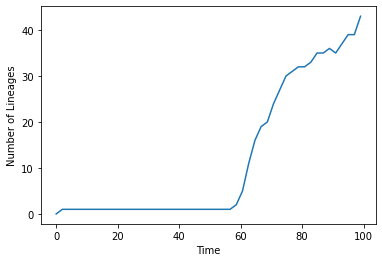

In [28]:
time_steps2 = np.linspace(0, tree2.max_distance_from_root(), 50)
ltt2 = [tree2.num_lineages_at(t) for t in time_steps2]
plt.plot(time_steps2, ltt2)
plt.xlabel('Time')
plt.ylabel('Number of Lineages')